This Jupyter worksheet is meant to give a quick overview on some statistics of all our patients, while also providing a clear statement on how this data was retrieved (with references to the fields within the Castor Forms)

In [54]:
# Import all requirements
import covid19_import 
import pandas as pd, numpy as np, requests, seaborn as sbn, pickle
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines

from covid19_ICU_admission import load_data_api, fix_single_errors, merge_study_and_report, calculate_outcome_measure, select_baseline_data

                                    Study ID        Record ID Form Type  \
0       2B1B90BA-69B8-48F5-BF2E-640284CB8709           000001       NaN   
1       2B1B90BA-69B8-48F5-BF2E-640284CB8709           000002       NaN   
2       2B1B90BA-69B8-48F5-BF2E-640284CB8709           110001       NaN   
3       2B1B90BA-69B8-48F5-BF2E-640284CB8709           110002       NaN   
4       2B1B90BA-69B8-48F5-BF2E-640284CB8709           110003       NaN   
...                                      ...              ...       ...   
158433  2B1B90BA-69B8-48F5-BF2E-640284CB8709  ARCHIVED-120088    Report   
158434  2B1B90BA-69B8-48F5-BF2E-640284CB8709  ARCHIVED-120088    Report   
158435  2B1B90BA-69B8-48F5-BF2E-640284CB8709  ARCHIVED-120088    Report   
158436  2B1B90BA-69B8-48F5-BF2E-640284CB8709  ARCHIVED-120088    Report   
158437  2B1B90BA-69B8-48F5-BF2E-640284CB8709  ARCHIVED-120088    Report   

                            Form Instance ID  \
0                                        NaN   
1  

ValueError: invalid literal for int() with base 10: 'Missing (not asked)'

# Get all data from Castor database
Note that you need export rights for every individual center.

In [ ]:
study_data,study_struct,reports_data,reports_struct,optiongroups_struct = covid19_import.import_data('/Users/wouterpotters/Desktop/')


## Export all variables to excel

In [34]:
target_excel = '/Users/wouterpotters/Desktop/covid19_variables.xlsx'
writer = pd.ExcelWriter(target_excel, engine='xlsxwriter')

readme = 'This excel sheet contains an overview of the variables that are used in the Castor EDC database for the COVID 19 project. \nThere are three tabs; \n(1) Admission variables; to be entered once and updated incidentally. \n(2) Daily reports are created once per day. \n(3) Complications are filled in as they arise.'
readme = pd.DataFrame([x for x in readme.split('\n')])

# Write each dataframe to a different worksheet.
readme.to_excel(writer, sheet_name='README',index=False)
#study_struct.to_excel(writer, sheet_name='AdmissionVariables',index=False)
#reports_struct.to_excel(writer, sheet_name='DailyUpdateVariables',index=False)
optiongroups_struct.to_excel(writer, sheet_name='OptionGroups',index=False)

# added answeroptions to the excel file
answeroptions = pd.pivot_table(optiongroups_struct,index='Option Group Id',values=['Option Name','Option Value'],aggfunc=lambda x:list(x))
answeroptions.rename(columns={'Option Name': 'Field Options Names','Option Value': 'Field Options Values'})
study_struct_withoptions = pd.merge(study_struct,answeroptions,how='left',left_on='Field Option Group',right_on='Option Group Id')
study_struct_withoptions.to_excel(writer, sheet_name='AdmissionVariables',index=False)

reports_struct_withoptions = pd.merge(reports_struct,answeroptions,how='left',left_on='Field Option Group',right_on='Option Group Id')
reports_struct_withoptions.to_excel(writer, sheet_name='DailyUpdateVariables',index=False)

writer.save() # save excel file

# Patient counts
## Total number of patients

In [36]:
print('Total number of patients (with any data) is: '+str(len(study_data)))

# HOSPITAL ADMISSION	ONSET & ADMISSION	admission_dt	Admission date at this facility:
has_admission_date = [x == False for x in study_data['admission_dt'].isna()]
print('Total number of patients with admission date: '+str(len(study_data[has_admission_date])))

# HOSPITAL ADMISSION	ONSET & ADMISSION	facility_transfer	Transfer from other facility?
# YES-facility is a study site	1
# YES-facility is not a study site	2
# No	3
# HOSPITAL ADMISSION	ONSET & ADMISSION	admission_facility_dt	Admission date at transfer facility
is_transferred = [(x == '1' or x == '2') for x in study_data['facility_transfer']]
has_transfer_admission_date = [x == False for x in study_data['admission_facility_dt'].isna()]
print('  > Transferred from other center: '+str(len(study_data[is_transferred]))+' (original admission date available in '+str(len(study_data[has_transfer_admission_date]))+'/'+str(len(study_data[is_transferred]))+')')

# TREATMENT	TREATMENTS during admission	Admission_dt_icu_1	Admission date ICU
has_ICU_admission_date = [x == False for x in study_data['Admission_dt_icu_1'].isna()]
# TREATMENT	TREATMENTS during admission	Discharge_dt_icu_1	Discharge date ICU
print('  > ICU admissions: '+str(len(study_data[has_ICU_admission_date])))
has_ICU_discharge_date = [x == False for x in study_data['Discharge_dt_icu_1'].isna()]
print('  > Discharged ICU admissions: '+str(len(study_data[has_ICU_admission_date and has_ICU_discharge_date])))


Total number of patients (with any data) is: 376
Total number of patients with admission date: 355
  > Transferred from other center: 62 (original admission date available in 61/62)
  > ICU admissions: 69
  > Discharged ICU admissions: 24


## Duration of hospital stay
1) Select all patients that are admitted to the hospital AND were at the ICU at some point.



In [37]:
# HOSPITAL ADMISSION	ONSET & ADMISSION	admission_dt	Admission date at this facility:
has_admission_date = [x == False for x in study_data['admission_dt'].isna()]

has_outcome_date = [x == False for x in study_data['Outcome_dt'].isna()] # = discharge date

# TREATMENT	TREATMENTS during admission	Admission_dt_icu_1	Admission date ICU
has_ICU_admission_date = [x == False for x in study_data['Admission_dt_icu_1'].isna()]

# fix all 11-11-1111 dates to NaN
study_data = study_data.replace(to_replace='11-11-1111', value=np.nan)

2) Calculate time (in days) from admission to ICU admission



In [38]:
# convert string to dates
patient_ICU_dates_admissions = pd.DataFrame([pd.to_datetime(study_data[x][has_admission_date and has_ICU_admission_date]) for x in study_data[['admission_dt','Admission_dt_icu_1']]]).transpose()
patient_ICU_dates_discharge_ICU = pd.DataFrame([pd.to_datetime(study_data[x][has_admission_date and has_ICU_admission_date and has_ICU_discharge_date]) for x in study_data[['Admission_dt_icu_1','Discharge_dt_icu_1']]]).transpose()

time_from_hospital_admission_to_ICU = patient_ICU_dates_admissions['Admission_dt_icu_1'] - patient_ICU_dates_admissions['admission_dt']
time_from_ICU_admission_to_ICU_discharge = patient_ICU_dates_discharge_ICU['Discharge_dt_icu_1'] - patient_ICU_dates_discharge_ICU['Admission_dt_icu_1']

print('These patients have a negative time difference between admission and ICU admission:')
print(time_from_hospital_admission_to_ICU[[x.days < 0 for x in time_from_hospital_admission_to_ICU]])
print()
print('These patients have a negative time difference between ICU admission and ICU discharge:')
print(time_from_ICU_admission_to_ICU_discharge[[x.days < 0 for x in time_from_ICU_admission_to_ICU_discharge]])
print()



# average stay on ICU
valid_ICU_durations_complete = time_from_ICU_admission_to_ICU_discharge[[x.days > 0 for x in time_from_ICU_admission_to_ICU_discharge]]/pd.Timedelta(days=1)
print('Mean +/- std ICU stay (n=' + str(len(valid_ICU_durations_complete)) + ' discharged patients): '+ str(np.mean(valid_ICU_durations_complete)) + ' days +/- ' + str(np.std(valid_ICU_durations_complete)) + ' days')



These patients have a negative time difference between admission and ICU admission:
Record ID
110029     -3 days
120008     -3 days
140010   -173 days
dtype: timedelta64[ns]

These patients have a negative time difference between ICU admission and ICU discharge:
Record ID
130002     -1 days
140012   -263 days
dtype: timedelta64[ns]

Mean +/- std ICU stay (n=20 discharged patients): 3.4 days +/- 2.0832666655999654 days



3) Calculate time on ICU (with active and discharged patients)


Mean +/- std ICU stay (n=67 discharged and nondischarged patients): 6.83 +/- 4.05 days.


(0.0, 19.95)

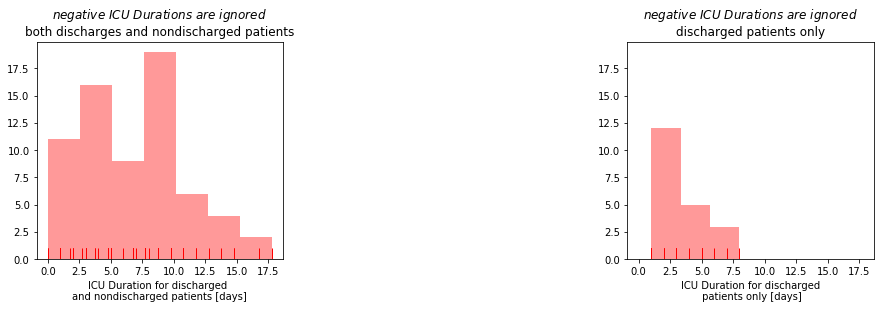

In [42]:
all_ICU_patients = pd.DataFrame([pd.to_datetime(study_data[x][has_admission_date and has_ICU_admission_date]) for x in study_data[['Admission_dt_icu_1','Discharge_dt_icu_1']]]).transpose()
all_ICU_patients = all_ICU_patients.fillna(datetime.now())

time_on_ICU = all_ICU_patients['Discharge_dt_icu_1']-all_ICU_patients['Admission_dt_icu_1']
valid_ICU_durations_days = time_on_ICU[[x.days >= 0 for x in time_on_ICU]]/pd.Timedelta(days=1)

# ignore ICU stays op < 0 days
print('Mean +/- std ICU stay (n=' + str(len(valid_ICU_durations_days)) + ' discharged and nondischarged patients): '+ str(round(np.mean(valid_ICU_durations_days),2)) + ' +/- ' + str(round(np.std(valid_ICU_durations_days),2)) + ' days.')
fig = plt.figure(figsize=[15, 4])

ax1 = fig.add_subplot(131)
sbn.distplot(valid_ICU_durations_days, hist=True, kde=False, rug=True, color='red')
plt.xlabel("ICU Duration for discharged \nand nondischarged patients [days]");
plt.title('$\it{negative\ ICU\ Durations\ are\ ignored}$\n'+\
          'both discharges and nondischarged patients');

ax2 = fig.add_subplot(133)
sbn.distplot(valid_ICU_durations_complete, hist=True, kde=False, rug=True, color='red')
plt.xlabel("ICU Duration for discharged\n patients only [days]");
plt.title('$\it{negative\ ICU\ Durations\ are\ ignored}$\n'+\
          'discharged patients only');

ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax1.get_ylim())

## Outcome so far
1) Alle van de ICU ontslagen (discharged) patienten

2) Outcome van alle ontslagen patienten


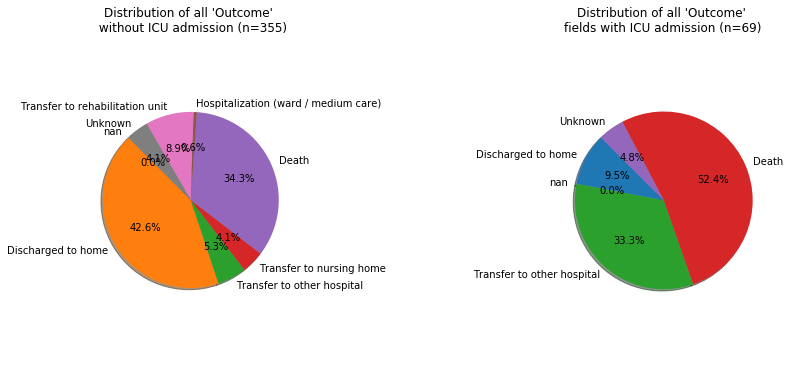

In [43]:
def namevaluedict(fieldname):
    answeroptions = pd.pivot_table(optiongroups_struct,index='Option Group Id',values=['Option Name','Option Value'],aggfunc=lambda x:list(x))
    selected = study_struct['Field Option Group'][study_struct['Field Variable Name']==fieldname]
    match = answeroptions.index.isin(study_struct['Field Option Group'][study_struct['Field Variable Name']==fieldname])
    answeroptions = answeroptions[match]
    return [str(i) for i in answeroptions['Option Value'][0]],answeroptions['Option Name'][0]

discharge_code_all = study_data['Outcome'][(([not i for i in has_ICU_admission_date]) and has_admission_date)]
n,v = namevaluedict('Outcome')
discharge_names = discharge_code_all.replace(to_replace=n, value=v).replace(to_replace='0',value='status 0; not filled in?')
discharge_names_un =  discharge_names.unique()
discharge_counts = [sum(discharge_names == d) for d in discharge_names_un]

fig = plt.figure(figsize=[12, 6])

ax1 = fig.add_subplot(131)
ax1.pie(discharge_counts, labels=discharge_names_un, autopct='%1.1f%%',
        shadow=True, startangle=135)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of all \'Outcome\' \n without ICU admission (n='+str(len(discharge_code_all))+')')
discharge_code_ICUonly = study_data['Outcome'][has_ICU_admission_date]
discharge_names = discharge_code_ICUonly.replace(to_replace=n, value=v).replace(to_replace='0',value='status 0; not filled in?')
discharge_names_un =  discharge_names.unique()
discharge_counts = [sum(discharge_names == d) for d in discharge_names_un]

ax2 = fig.add_subplot(133)
ax2.pie(discharge_counts, labels=discharge_names_un, autopct='%1.1f%%',
        shadow=True, startangle=135)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of all \'Outcome\' \nfields with ICU admission (n='+str(len(discharge_code_ICUonly))+')')
plt.show()

## Individual variable distribution
Code by: Willem Bruin


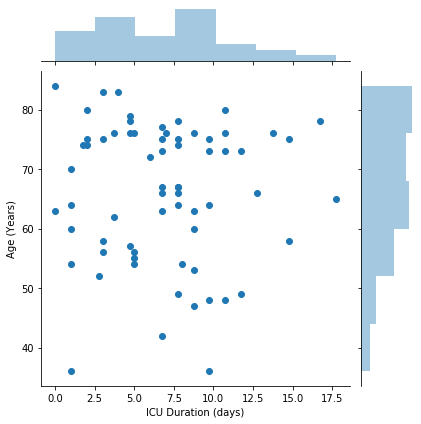

In [49]:
# Calculate age in years
age_in_years = (datetime.now().year - \
                pd.DatetimeIndex(study_data[has_admission_date and has_ICU_admission_date]['age']).year)

valid_age = age_in_years[[x.days >= 0 for x in time_on_ICU]] # Skip patients with negative ICU Duration

data = pd.DataFrame(data=np.array([valid_ICU_durations_days, valid_age]).T, columns=['ICU Duration (days)', 'Age (Years)'])

fig = sbn.jointplot(data=data, x="ICU Duration (days)", y="Age (Years)")

# Save to pdf
# figure_dir = 'C:\\Users\\AMC\\Desktop\\\WouterP\\covid19_CDSS\\Figures\\'
# fig.savefig(osp.join(figure_dir, 'JointPlot_Age_Duration' + datetime.today().strftime("_%d_%m_%Y") + '.pdf')) 

# All variables

In [53]:
VARS_OF_INTEREST = study_data.columns
df = study_data
# add in age in years
df['age_in_years'] = (datetime.now().year - \
                     pd.DatetimeIndex(df['age']).year)

VARS_OF_INTEREST = np.append('age_in_years', VARS_OF_INTEREST)

index_no_ICU = ~np.array(has_ICU_admission_date) & has_admission_date
index_ICU_only = has_ICU_admission_date

for c in VARS_OF_INTEREST[:10]:
    
    try:
        fig = plt.figure(figsize=[15, 5])
#         fig.suptitle('{}'.format(c), fontsize=16)

        ax1 = fig.add_subplot(131)
        sbn.distplot(df[index_no_ICU][c].values, hist=True, kde=False, rug=True, color='red', ax=ax1, bins=10)
        plt.title('Patients without ICU admision (n={})'.format(sum(index_no_ICU)))
        
        tmp_no_ICU = df[index_no_ICU][c].values
        tmp_ICU_only = df[index_ICU_only][c].values
        
        ax3 = fig.add_subplot(132)
        ax3.axis('off')
        ax3.text(0.5, 1.1, c, size=20, ha="center", va="center")
        
        try: 
            # TODO, write out descriptives in between
            nan_mean_1, nan_std_1 = '{:.2f}'.format(np.nanmean(tmp_no_ICU)), '{:.2f}'.format(np.nanstd(tmp_no_ICU))
            nan_mean_2, nan_std_2 = '{:.2f}'.format(np.nanmean(tmp_ICU_only)), '{:.2f}'.format(np.nanstd(tmp_ICU_only))

            ax3.text(0.15, 0.9, 'Mean (STD):', size=15, ha="center", va="bottom")
            ax3.text(0.15, 0.8, str(nan_mean_1) + ' (' +  str(nan_std_1) + ')', size=15, ha="center", va="center")

            ax3.text(0.85, 0.9, 'Mean (STD):', size=15, ha="center", va="bottom")
            ax3.text(0.85, 0.8, str(nan_mean_2) + ' (' +  str(nan_std_2) + ')', size=15, ha="center", va="center")
        except:
            print("Variable {} not continous? Skipping descriptives!".format(c))
            print()
            print()
        
        ax2 = fig.add_subplot(133)
        sbn.distplot(df[index_ICU_only][c].values, hist=True, kde=False, rug=True, color='red', ax=ax2, bins=10)
        plt.title('Patients with ICU admission (n={})'.format(sum(index_ICU_only)))

        plt.show()
    
    except:
        print("Variable {} not found! Skipping.. ".format(c))
        print()
        print()

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 2939-09-14 00:00:00

## Train logistic regression model
code by: Maarten Ottenhof

In [46]:
import covid19_ICU_admission


                                    Study ID        Record ID Form Type  \
0       2B1B90BA-69B8-48F5-BF2E-640284CB8709           000001       NaN   
1       2B1B90BA-69B8-48F5-BF2E-640284CB8709           000002       NaN   
2       2B1B90BA-69B8-48F5-BF2E-640284CB8709           110001       NaN   
3       2B1B90BA-69B8-48F5-BF2E-640284CB8709           110002       NaN   
4       2B1B90BA-69B8-48F5-BF2E-640284CB8709           110003       NaN   
...                                      ...              ...       ...   
158094  2B1B90BA-69B8-48F5-BF2E-640284CB8709  ARCHIVED-120088    Report   
158095  2B1B90BA-69B8-48F5-BF2E-640284CB8709  ARCHIVED-120088    Report   
158096  2B1B90BA-69B8-48F5-BF2E-640284CB8709  ARCHIVED-120088    Report   
158097  2B1B90BA-69B8-48F5-BF2E-640284CB8709  ARCHIVED-120088    Report   
158098  2B1B90BA-69B8-48F5-BF2E-640284CB8709  ARCHIVED-120088    Report   

                            Form Instance ID  \
0                                        NaN   
1  

ValueError: invalid literal for int() with base 10: 'Missing (not asked)'

In [47]:
# Calculate age in years
age_in_years = (datetime.now().year - \
                pd.DatetimeIndex(df[has_admission_date and has_ICU_admission_date]['age']).year)

valid_age = age_in_years[[x.days >= 0 for x in time_on_ICU]] # Skip patients with negative ICU Duration

data = pd.DataFrame(data=np.array([valid_ICU_durations_days, valid_age]).T, columns=['ICU Duration (days)', 'Age (Years)'])

fig = sbn.jointplot(data=data, x="ICU Duration (days)", y="Age (Years)")

# Save to pdf
# figure_dir = 'C:\\Users\\AMC\\Desktop\\\WouterP\\covid19_CDSS\\Figures\\'
# fig.savefig(osp.join(figure_dir, 'JointPlot_Age_Duration' + datetime.today().strftime("_%d_%m_%Y") + '.pdf'))

NameError: name 'df' is not defined

In [ ]:
# huidig aantal COVID patiënten in rest van ZH
# kans van gemiddelde COVID zaal / MC patiënt naar IC moet < 24 uur. < 48 uur, < 72 uur 
# kans dat gemiddelde COVID zaal patiënt kan worden ontslagen < 24 uur. < 48 uur, < 72 uur 
# kans dat gemiddelde IC patiënt nog 24, 48 en 72 uur op IC moet blijven 
# duur van gemiddelde zaal / MC opname
# te verwachten gemiddelde resterende duur van zaal / MC opname 
# te verwachten gemiddelde resterende duur van IC opname
# % aantal opgenomen patiënten met te verwachten goede outcome (naar huis), met te verwachten redelijke outcome (revalidatie), matige outcome (verpleegtehuis), slechte outcome (palliatie, overlijden)
# code waarin staat hoe het met de capaciteit in ZH is obv voor Corona beschikbare bedden - groen oranje rood zwart
# (aantal patiënten dat optimale behandeling krijgt - controversieel - niet in 1.0 versie

ModuleNotFoundError: No module named 'geopandas'